# importing libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown
from glob import glob
import cv2

In [2]:
from skimage.filters import gaussian
import scipy.io as io
from skimage import color

# Mount dataset from google drive

I loaded dataset from kaggle to my google drive and load dataset from google drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load train and test images and ground truth

In [5]:
def read_train_images(folder_path):
  images_path = sorted(glob(folder_path+'/*.jpg'))
  output = []
  for path in images_path:
    img = cv2.imread(path)#.resize(225, 225)
    output.append(img)
  return np.array(output)

In [6]:
def read_groundtruth(folder_path):
  images_path = sorted(glob(folder_path+'/*.mat'))
  output = []
  for path in images_path:
    mat = io.loadmat(path)
    gt = mat["image_info"][0,0][0,0][0]
    output.append(gt)
  return np.array(output)

In [8]:
train_img = read_train_images('/content/gdrive/MyDrive/kaggle/ShanghaiTech/part_B/train_data/images')

In [7]:
ground_truth = read_groundtruth('/content/gdrive/MyDrive/kaggle/ShanghaiTech/part_B/train_data/ground-truth')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [9]:
test_img = read_train_images('/content/gdrive/MyDrive/kaggle/ShanghaiTech/part_B/test_data/images')

In [10]:
test_ground_truth = read_groundtruth('/content/gdrive/MyDrive/kaggle/ShanghaiTech/part_B/test_data/ground-truth')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


# Create Test data and test labels

 - first rescale test ground truth : 1/16 of real ground truth because label size (65\*65) is approximately 1/16 of real images (768*1024)
 - resize test images to 260*260
 - create a matrix for gaussian filter with rescaled ground truth
 - apply gaussian filter for every matrix that we made  
 now our labels are made and we can that sum of each labels matrix indicates number of peaple in that image  
 at the end we save test data with its labels

In [12]:
scaled_test_gt = test_ground_truth/16

In [13]:
scaled_test_imgs = [cv2.resize(i, dsize=(260, 260), interpolation=cv2.INTER_CUBIC) for i in test_img]

In [14]:
def create_k_matrix(gt,img_shape):
  output = []
  j = 0
  for grnd in gt:
    k = np.zeros((img_shape[0],img_shape[1]))
    for i in range(0,len(grnd)):
      if int(grnd[i][1])<img_shape[0] and int(grnd[i][0])<img_shape[1]:
        k[int(grnd[i][1]),int(grnd[i][0])]=1
    output.append(k)
  return np.array(output)

In [15]:
test_k = create_k_matrix(scaled_test_gt, (65,65))

In [16]:
def gaussian_filter_pass(K_matrix):
  output = []
  j=0
  for k in K_matrix:
    density = np.zeros(k.shape, dtype=np.float32)
    pts = np.array(list(zip(np.nonzero(k)[1], np.nonzero(k)[0])))
    for i, pt in enumerate(pts):
      pt2d = np.zeros(k.shape, dtype=np.float32)
      pt2d[pt[1],pt[0]] = 1.
      density += gaussian(pt2d, sigma=3, mode='nearest')
    output.append(density)
    j += 1
    if j%50 ==0:
      print(f'{j} images are labeled!')
  return np.array(output)

In [17]:
test_labels = gaussian_filter_pass(test_k)

50 images are labeled!
100 images are labeled!
150 images are labeled!
200 images are labeled!
250 images are labeled!
300 images are labeled!


In [18]:
test_data = [[scaled_test_imgs[i], test_labels[i]] for i in range(len(test_labels))]

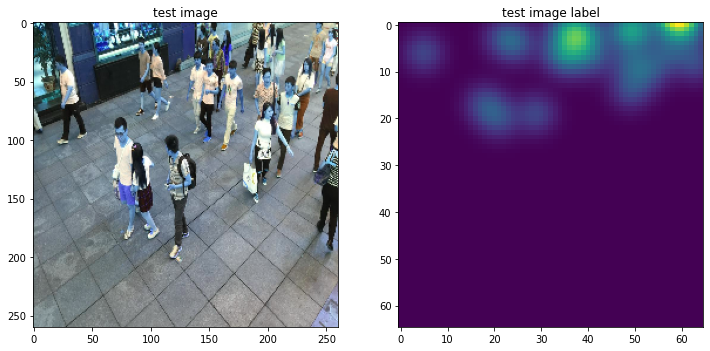

In [19]:
fig=plt.figure(figsize=(12, 35))
fig.add_subplot(1, 2, 1)
plt.title("test image")
plt.imshow(test_data[0][0])
fig.add_subplot(1, 2, 2)
plt.title("test image label")
plt.imshow(test_data[0][1])

In [ ]:
np.save('Test_data', np.array(test_data))

# Create Train data and Train labels

 - first we create 9 random patches for each image with 260 * 260 dimensions   
 for each patch:  
  - rescale the ground truth point 
  - create a matrix for gaussian filter with rescaled ground truth
 - apply gaussian filter for every patch matrixes that we made  
 
 now our labels are made and we can that sum of each labels matrix indicates number of peaple in that image  
 at the end we save train data with its labels

In [20]:
def create_train_k_matrix(grnd, img_shape):
  k = np.zeros((img_shape[0],img_shape[1]))
  for i in range(0,len(grnd)):
    if int(grnd[i][1])>=0 and int(grnd[i][0])>=0 and int(grnd[i][1])<img_shape[0] and int(grnd[i][0])<img_shape[1]:
      k[int(grnd[i][1]),int(grnd[i][0])]=1
  return k

In [23]:
def create_patches(imgs, gt, number_of_patches):
  data = []
  for i in range(len(imgs)):
    for j in range(number_of_patches):
      x = np.random.randint(0,imgs[0].shape[0]-260)
      y = np.random.randint(0,imgs[0].shape[1]-260)
      image_patch = imgs[i][x:x+260, y:y+260,:]
      image_gt = gt[i]/4
      image_gt = [[i[0] -y/4 , i[1] -x/4 ] for i in image_gt]
      label = create_train_k_matrix(image_gt,(65, 65))
      #label_patch = cv2.resize(label_patch, dsize=(int(label_patch.shape[0]/4), int(label_patch.shape[1]/4)), interpolation=cv2.INTER_CUBIC)
      data_point = [image_patch, label]
      data.append(data_point)
    if i%100==0:
      print(f'{i} data points processed!')
  return data

In [24]:
train_patches = create_patches(train_img, ground_truth, 9)

0 data points processed!
100 data points processed!
200 data points processed!
300 data points processed!


In [26]:
train_k = [i[1] for i in train_patches]

In [27]:
def gaussian_filter_pass(K_matrix):
  output = []
  j=0
  for k in K_matrix:
    density = np.zeros(k.shape, dtype=np.float32)
    pts = np.array(list(zip(np.nonzero(k)[1], np.nonzero(k)[0])))
    for i, pt in enumerate(pts):
      pt2d = np.zeros(k.shape, dtype=np.float32)
      pt2d[pt[1],pt[0]] = 1.
      density += gaussian(pt2d, sigma=3, mode='nearest')
    output.append(density)
    j += 1
    if j%50 ==0:
      print(f'{j} images are labeled!')
  return np.array(output)

In [28]:
train_labels = gaussian_filter_pass(train_k)

50 images are labeled!
100 images are labeled!
150 images are labeled!
200 images are labeled!
250 images are labeled!
300 images are labeled!
350 images are labeled!
400 images are labeled!
450 images are labeled!
500 images are labeled!
550 images are labeled!
600 images are labeled!
650 images are labeled!
700 images are labeled!
750 images are labeled!
800 images are labeled!
850 images are labeled!
900 images are labeled!
950 images are labeled!
1000 images are labeled!
1050 images are labeled!
1100 images are labeled!
1150 images are labeled!
1200 images are labeled!
1250 images are labeled!
1300 images are labeled!
1350 images are labeled!
1400 images are labeled!
1450 images are labeled!
1500 images are labeled!
1550 images are labeled!
1600 images are labeled!
1650 images are labeled!
1700 images are labeled!
1750 images are labeled!
1800 images are labeled!
1850 images are labeled!
1900 images are labeled!
1950 images are labeled!
2000 images are labeled!
2050 images are labe

In [29]:
train_data = [[train_patches[i][0], train_labels[i]] for i in range(len(train_labels))]

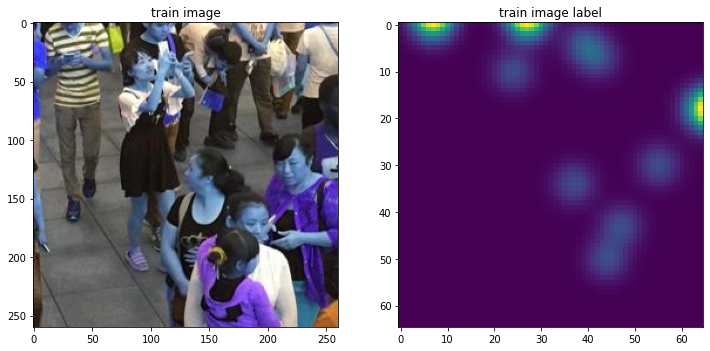

In [30]:
fig=plt.figure(figsize=(12, 35))
fig.add_subplot(1, 2, 1)
plt.title("train image")
plt.imshow(train_data[0][0])
fig.add_subplot(1, 2, 2)
plt.title("train image label")
plt.imshow(train_data[0][1])

In [ ]:
np.save('Train_data', np.array(train_data))

------------------------------------------------------------------------------------
# Create and train Model

! note: load saved data to run our model on GPU
preprocessing was on CPU because of colab time limitations

## load train data and grayscal images

In [ ]:
trainn = np.load('/content/gdrive/MyDrive/Train_data.npy', allow_pickle=True)

In [ ]:
train_data = []
for i in range(len(trainn)):
  image = trainn[i][0]
  train_data.append([color.rgb2gray(image),trainn[i][1] ])

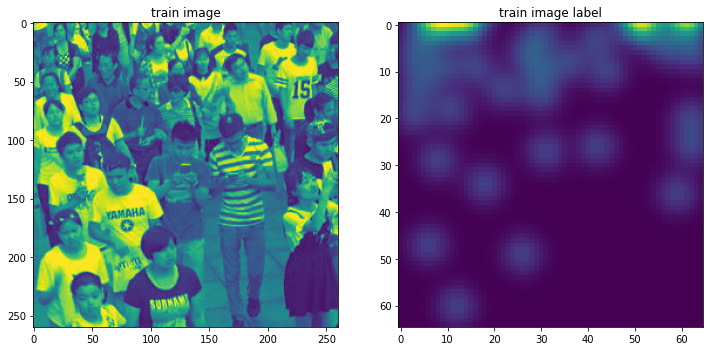

In [ ]:
fig=plt.figure(figsize=(12, 35))
fig.add_subplot(1, 2, 1)
plt.title("train image")
plt.imshow(train_data[0][0])
fig.add_subplot(1, 2, 2)
plt.title("train image label")
plt.imshow(train_data[0][1])

## load test data and grayscale images

In [ ]:
test = np.load('/content/gdrive/MyDrive/Test_data.npy', allow_pickle=True)

In [ ]:
test_data = []
for i in range(len(test)):
  image = test[i][0]
  test_data.append([color.rgb2gray(image), test[i][1]])

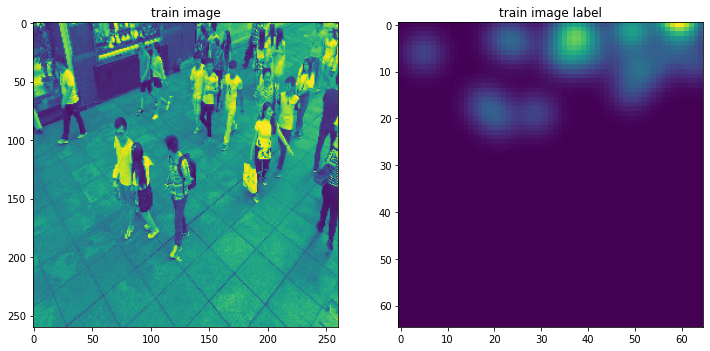

In [ ]:
fig=plt.figure(figsize=(12, 35))
fig.add_subplot(1, 2, 1)
plt.title("train image")
plt.imshow(test_data[0][0])
fig.add_subplot(1, 2, 2)
plt.title("train image label")
plt.imshow(test_data[0][1])

## convert data to batches with size of 32

In [ ]:
#torch.manual_seed(0)
train,valid = torch.utils.data.random_split(train_data,[3240,360])
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=32)
validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=32)

## create net with given structure

In [ ]:
class Ccnn(nn.Module):
  def __init__(self):
    super(Ccnn, self).__init__()
    self.Conv1 = nn.Conv2d(1, 32, kernel_size=11, stride=1, padding=5)
    self.Conv2 = nn.Conv2d(32, 32, kernel_size=7, stride=1, padding=3)
    self.Conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
    self.Conv4 = nn.Conv2d(64, 1000, kernel_size=1, stride=1)
    self.Conv5 = nn.Conv2d(1000, 400, kernel_size=1, stride=1)
    self.Conv6 = nn.Conv2d(400, 1, kernel_size=1, stride=1)
  
  def forward(self, x):
    #stage1
    x1 = F.relu(self.Conv1(x))
    #stage2
    x2 = F.relu(F.max_pool2d(self.Conv2(x1), kernel_size=2, stride=2))
    #stage3
    x3 = F.relu(F.max_pool2d(self.Conv3(x2), kernel_size=2, stride=2))
    #stage4
    x4 = F.relu(self.Conv4(x3))
    #stage5
    x5 = F.relu(self.Conv5(x4))
    #stage6
    x6 = F.relu(self.Conv6(x5))

    return x6



In [ ]:
model = Ccnn()

In [ ]:
import torch.optim as optim
import gc
optimizer =optim.Adam(model.parameters(), lr=0.0000005) 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [ ]:
model.to(device)

Ccnn(
  (Conv1): Conv2d(1, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (Conv2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (Conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Conv4): Conv2d(64, 1000, kernel_size=(1, 1), stride=(1, 1))
  (Conv5): Conv2d(1000, 400, kernel_size=(1, 1), stride=(1, 1))
  (Conv6): Conv2d(400, 1, kernel_size=(1, 1), stride=(1, 1))
)

## Train model

In [ ]:
losss = []
validation = []
maes = []
validation_mae = []
mses = []
validation_mses = []
for epoch in range(30):
    running_loss = 0.0
    running_mae = 0.0
    running_mse = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
    
        # forward + backward + optimize
        outputs = model(inputs.unsqueeze(1).float())
        # euclidean distance loss Function
        loss = torch.dist(outputs, labels, p=2)**2/(2*len(labels)) 
        loss.backward()
        optimizer.step()
        mae = torch.abs(outputs - labels).sum().data
        mse = ((outputs - labels)**2).sum().data

        # save statistics
        running_loss += loss.item()
        running_mae += mae.item()
        running_mse += mse.item()
        
    running_val_mae = 0.0
    running_valid_loss = 0.0
    running_val_mse = 0.0

    model.eval()
    for j, valid_data in enumerate(validloader,0):
      valid_inputs, valid_labels = valid_data[0].to(device),  valid_data[1].to(device)
       # forward + backward + optimize
      valid_outputs = model(valid_inputs.unsqueeze(1).float() )
      # euclidean distance loss Function
      valid_loss = torch.dist(valid_outputs, valid_labels, p=2)**2/(2*len(valid_labels))

      val_mae = torch.abs(valid_outputs - valid_labels).sum().data
      val_mse = ((valid_outputs - valid_labels)**2).sum().data
      running_valid_loss += valid_loss.item()
      running_val_mae += val_mae.item()
      running_val_mse += val_mse.item()

    print(f'epoch: {epoch} -  loss :{running_loss / (i+1)} - validation loss : {running_valid_loss/(j+1)} - train mae: {running_mae/(i+1)} - val_mae = {running_val_mae/(j+1)} - train mse = {np.sqrt(running_mse/(i+1))} - val_mse = {np.sqrt(running_val_mse/(j+1))}')
    losss.append(running_loss / (i+1))
    validation.append(running_valid_loss/(j+1))
    maes.append(running_mae/ (i+1))
    mses.append(np.sqrt(running_mse/(i+1)))
    validation_mae.append(running_val_mae / (j+1))
    validation_mses.append(np.sqrt(running_val_mse/(j+1)))

    running_loss = 0.0
    running_valid_loss = 0.0
    running_val_mae = 0.0
    running_mae = 0.0

    torch.cuda.empty_cache()
    gc.collect()
    # saving model
    torch.save(model.cpu().state_dict(), 'final_model.pth') 
    model.cuda()
    
print('Finished Training')

epoch: 0 -  loss :64.96294683568618 - validation loss : 43.51464716593424 - train mae: 130608.91822725184 - val_mae = 101815.32784016927 - train mse = 64.43862009060717 - val_mse = 52.315967185132585
epoch: 1 -  loss :32.527751230726054 - validation loss : 20.959500114123028 - train mae: 90678.04676968444 - val_mae = 68178.109375 - train mse = 45.59842970830832 - val_mse = 36.37268369275861
epoch: 2 -  loss :14.986905272100486 - validation loss : 9.999039053916931 - train mae: 58336.187887752756 - val_mae = 42188.54262288412 - train mse = 30.95636044511011 - val_mse = 25.13789433455022
epoch: 3 -  loss :7.593946683640573 - validation loss : 6.251298815011978 - train mae: 35945.670282102095 - val_mae = 26223.130564371746 - train mse = 22.034396319700576 - val_mse = 19.89923620898804
epoch: 4 -  loss :5.34878321722442 - validation loss : 5.306850115458171 - train mae: 23000.340716193703 - val_mae = 17832.973225911457 - train mse = 18.396277015741145 - val_mse = 18.33917231199018
epoch: 5

## Results

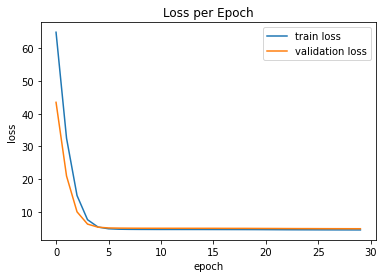

In [ ]:
plt.title("Loss per Epoch")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.plot(losss, label ="train loss")
plt.plot(validation, label = "validation loss")
plt.legend()
plt.show()

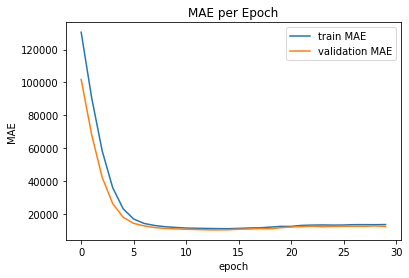

In [ ]:
plt.title("MAE per Epoch")
plt.ylabel("MAE")
plt.xlabel("epoch")
plt.plot(maes, label ="train MAE")
plt.plot(validation_mae, label = "validation MAE")
plt.legend()
plt.show()

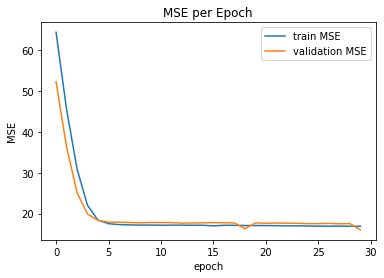

In [ ]:
plt.title("MSE per Epoch")
plt.ylabel("MSE")
plt.xlabel("epoch")
plt.plot(mses, label ="train MSE")
plt.plot(validation_mses, label = "validation MSE")
plt.legend()
plt.show()

## test Model

In [ ]:
testloader = torch.utils.data.DataLoader(test_data)

In [ ]:
def test_model(model, test_lodaer):
  out=[]
  test_img = []
  test_label = []
  test_mse, test_mae = 0.0, 0.0
  for i in testloader:
    with torch.no_grad():
      test_,test_lbl = i[0],i[1]
      torch.cuda.empty_cache()
      out1 = model(test_.unsqueeze(1).float().to(device))
      mae = torch.abs(out1 - test_lbl.to(device)).sum().data
      mse = ((out1 - test_lbl.to(device))**2).sum().data
      test_mae += mae.item()
      test_mse += mse.item()
      torch.cuda.empty_cache()
      out.append(out1)
      test_img.append(test_[0])
      test_label.append(test_lbl[0])
  pred =[out[i].squeeze(1).cpu().detach().numpy()[0] for i in range(len(out))]
  real_images = [test_img[i] for i in range(len(test_img))]
  real_labels = [test_label[i] for i in range(len(test_label))]
  return pred, real_labels, real_images, test_mae/len(pred), np.sqrt(test_mse/len(pred))

In [ ]:
y_pred, y_true,test_imgs, mae, mse = test_model(model, testloader)

In [ ]:
print(f'mea of test data is {mae}\nmse of test data {mse}')

mea of test data is 106.06541583809671
mse of test data 4.516564184268435


In [ ]:
def plot_test(y_pred, y_true, images):
  fig=plt.figure(figsize=(25, 25))
  i=0
  j=0
  for i in range(4):
    j+=1
    #print(out[0].size())
    fig.add_subplot(4, 3, j)
    plt.title('Network Output')
    plt.imshow(y_pred[i])
    plt.xlabel(f'number of people in predicted label = {np.sum(y_pred[i])}')
    j+=1
    fig.add_subplot(4, 3, j)
    plt.title('real label')
    plt.imshow(y_true[i])
    plt.xlabel(f'number of people in real label = {np.sum(np.array(y_true[i]))}')
    j+=1
    fig.add_subplot(4, 3, j)
    plt.title("real images")
    plt.imshow(images[i])

  plt.show()



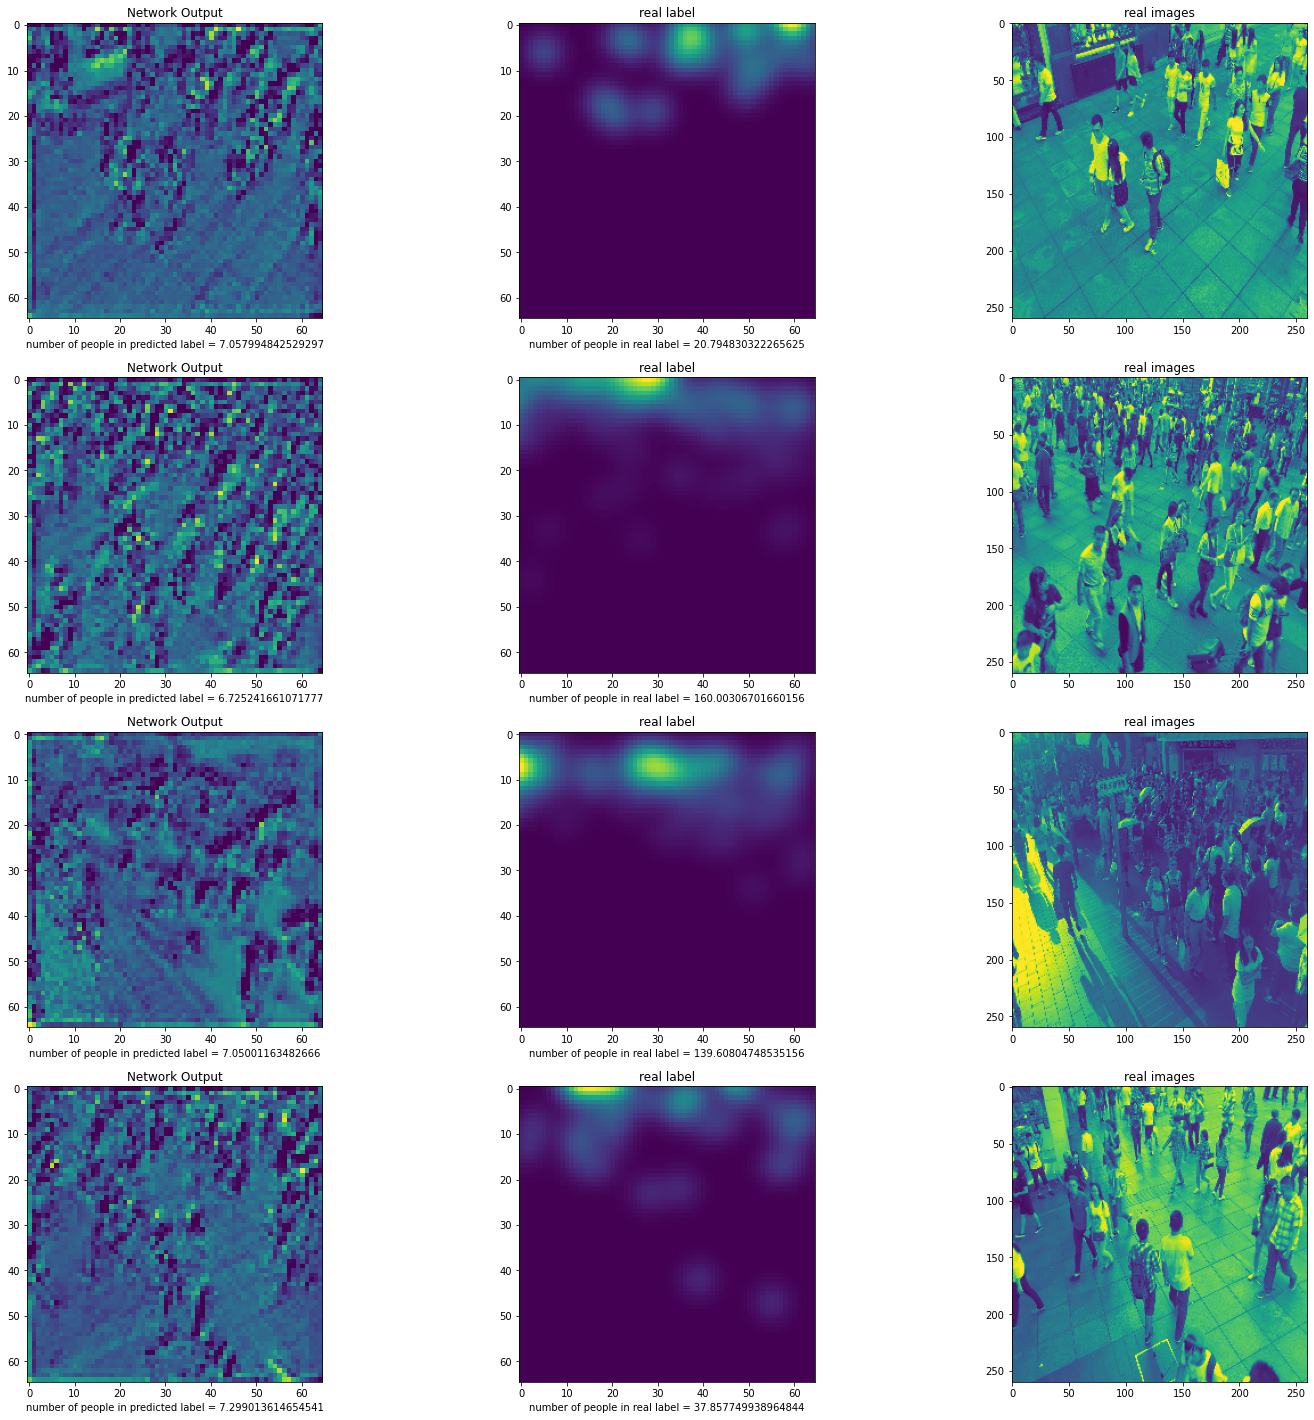

In [ ]:
plot_test(y_pred, y_true, test_imgs)

# create more date with Augmentation

In [ ]:
import imgaug.augmenters as iaa

In [ ]:
augments = [iaa.Sequential([iaa.Fliplr(0.5)]),
       iaa.Sequential([iaa.LinearContrast((0.75, 1.5))]),
       iaa.Sequential([ iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})]),
       iaa.Sequential([ iaa.Affine(rotate=(-25, 25))]),
       iaa.Sequential([iaa.Affine(shear=(-8, 8))])]

In [ ]:
#torch.manual_seed(0)
train,valid = torch.utils.data.random_split(train_data,[3240,360])
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=32)
validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=32)

In [ ]:
i1, l1 = next(iter(trainloader))
print(i1.shape)

torch.Size([32, 260, 260])


In [ ]:
model = Ccnn()

In [ ]:
import torch.optim as optim
import gc
optimizer =optim.Adam(model.parameters(), lr=0.0000005) 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [ ]:
model.to(device)

Ccnn(
  (Conv1): Conv2d(1, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (Conv2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (Conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Conv4): Conv2d(64, 1000, kernel_size=(1, 1), stride=(1, 1))
  (Conv5): Conv2d(1000, 400, kernel_size=(1, 1), stride=(1, 1))
  (Conv6): Conv2d(400, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
aug_losss = []
aug_validation = []
aug_maes = []
aug_validation_mae = []
aug_mses = []
aug_validation_mses = []
for epoch in range(30):  
    running_loss = 0.0
    running_mae = 0.0
    running_mse = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0], data[1]
        # random augmentation
        random_augment = np.random.randint(0,len(augments))
        # apply augmentation
        images_aug = augments[random_augment](images=inputs)
        labels_aug = augments[random_augment](images=labels)
        p = 0.4
        idx = torch.randperm(inputs.size(0))[:int(inputs.size(0)*p)]
        #concat augmented data with real data of each batch
        inputs = torch.cat((inputs, torch.tensor(images_aug)[idx])).to(device)
        labels = torch.cat((labels,torch.tensor(labels_aug)[idx])).to(device)
  
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs.unsqueeze(1).float())
        # euclidean distance loss Function
        loss = torch.dist(outputs, labels, p=2)**2/(2*len(labels)) 
        loss.backward()
        optimizer.step()
        mae = torch.abs(outputs - labels).sum().data
        mse = ((outputs - labels)**2).sum().data

        # save statistics
        running_loss += loss.item()
        running_mae += mae.item()
        running_mse += mse.item()
        
    running_val_mae = 0.0
    running_valid_loss = 0.0
    running_val_mse = 0.0
    model.eval()
    for j, valid_data in enumerate(validloader,0):
      valid_inputs, valid_labels = valid_data[0].to(device),  valid_data[1].to(device)
       
      valid_outputs = model(valid_inputs.unsqueeze(1).float() )
      # euclidean distance loss Function
      valid_loss = torch.dist(valid_outputs, valid_labels, p=2)**2/(2*len(valid_labels))
      val_mse = ((valid_outputs - valid_labels)**2).sum().data
      running_valid_loss += valid_loss.item()
      running_val_mae += val_mae.item()
      running_val_mse += val_mse.item()

    print(f'epoch: {epoch} -  loss :{running_loss / (i+1)} - validation loss : {running_valid_loss/(j+1)} - train mae: {running_mae/(i+1)} - val_mae = {running_val_mae/(j+1)} - train mse = {np.sqrt(running_mse/(i+1))} - val_mse = {np.sqrt(running_val_mse/(j+1))}')
    aug_losss.append(running_loss / (i+1))
    aug_validation.append(running_valid_loss/(j+1))
    aug_maes.append(running_mae/ (i+1))
    aug_mses.append(np.sqrt(running_mse/(i+1)))
    aug_validation_mae.append(running_val_mae / (j+1))
    aug_validation_mses.append(np.sqrt(running_val_mse/(j+1)))

    running_loss = 0.0
    running_valid_loss = 0.0
    running_val_mae = 0.0
    running_mae = 0.0
    
    torch.cuda.empty_cache()
    gc.collect()
    
    torch.save(model.cpu().state_dict(), 'final_model.pth') # saving model
    model.cuda()

print('Finished Training')

epoch: 0 -  loss :107.7096315458709 - validation loss : 51.411068757375084 - train mae: 271393.1906403186 - val_mae = 111704.33536783855 - train mse = 97.28989236923324 - val_mse = 56.870516690462175
epoch: 1 -  loss :54.31455305510876 - validation loss : 24.05628216266632 - train mae: 189098.79082414217 - val_mae = 74638.8321126302 - train mse = 69.09390174305818 - val_mse = 38.95540810820848
epoch: 2 -  loss :26.045987395679248 - validation loss : 10.805325388908386 - train mae: 122334.65397614124 - val_mae = 46116.730224609375 - train mse = 47.84776469741794 - val_mse = 26.08393946502982
epoch: 3 -  loss :13.192544792212692 - validation loss : 5.891315937042236 - train mae: 75046.62599571078 - val_mae = 28285.049641927082 - train mse = 34.05489852253246 - val_mse = 19.217666206711378
epoch: 4 -  loss :9.324458172508315 - validation loss : 4.246363272269567 - train mae: 49354.16475423177 - val_mae = 19509.482503255207 - train mse = 28.626516434443825 - val_mse = 16.391983075361544
ep

## Results

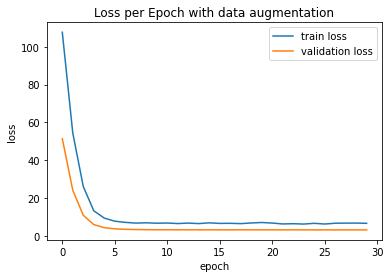

In [ ]:
plt.title("Loss per Epoch with data augmentation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.plot(aug_losss, label ="train loss")
plt.plot(aug_validation, label = "validation loss")
plt.legend()
plt.show()

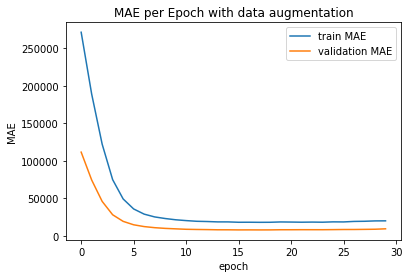

In [ ]:
plt.title("MAE per Epoch with data augmentation")
plt.ylabel("MAE")
plt.xlabel("epoch")
plt.plot(aug_maes, label ="train MAE")
plt.plot(aug_validation_mae, label = "validation MAE")
plt.legend()
plt.show()

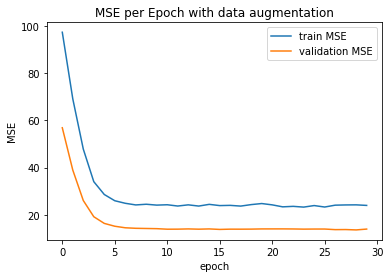

In [ ]:
plt.title("MSE per Epoch with data augmentation")
plt.ylabel("MSE")
plt.xlabel("epoch")
plt.plot(aug_mses, label ="train MSE")
plt.plot(aug_validation_mses, label = "validation MSE")
plt.legend()
plt.show()

In [ ]:
y_pred, y_true,test_imgs, mae, mse = test_model(model, testloader)

In [ ]:
print(f'mea of test data is {mae}\nmse of test data {mse}')

mea of test data is 105.70846700668335
mse of test data 4.5304163217968165


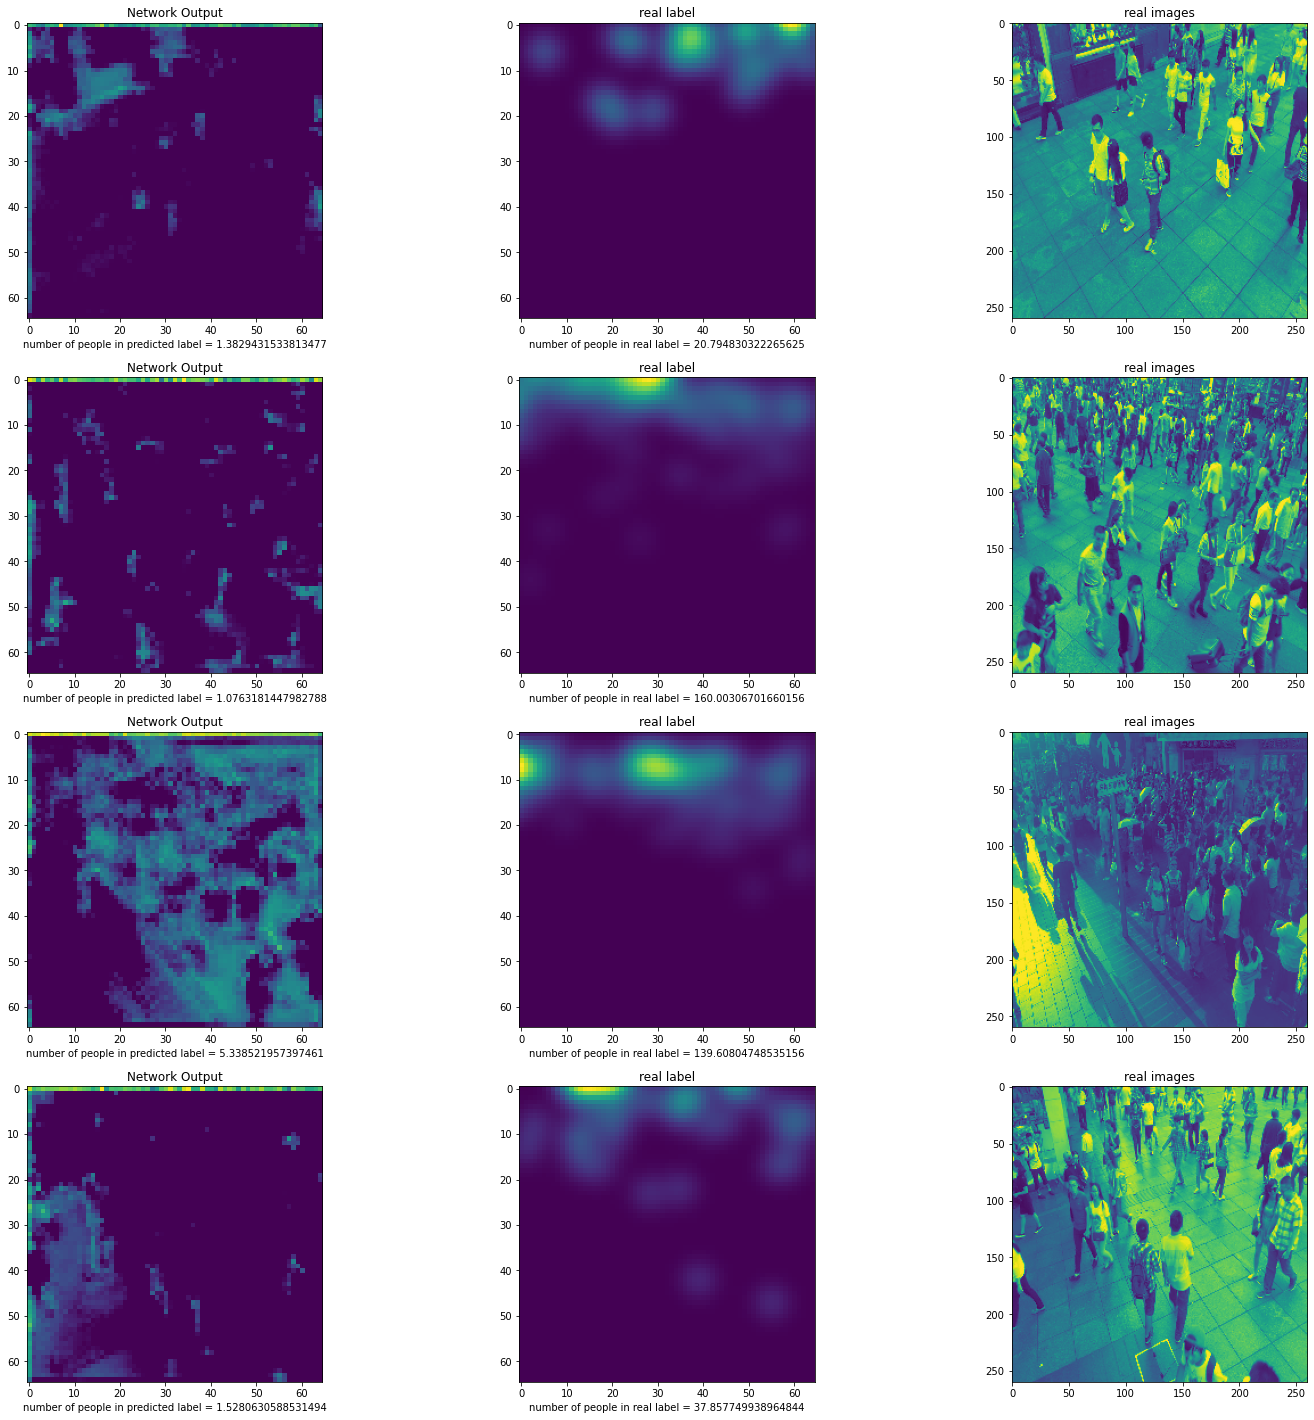

In [ ]:
plot_test(y_pred, y_true, test_imgs)

# Comparison

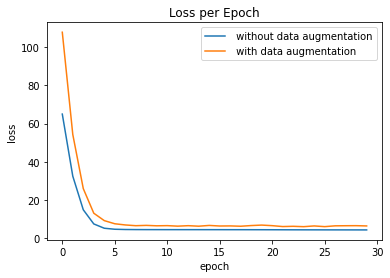

In [ ]:
plt.title("Loss per Epoch")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.plot(losss, label =" without data augmentation")
plt.plot(aug_losss, label = " with data augmentation")
plt.legend()
plt.show()

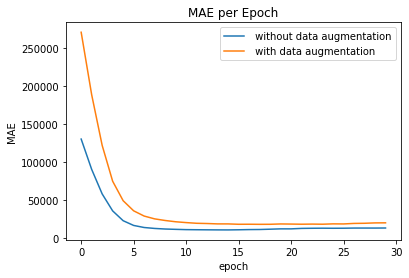

In [ ]:
plt.title("MAE per Epoch")
plt.ylabel("MAE")
plt.xlabel("epoch")
plt.plot(maes, label =" without data augmentation")
plt.plot(aug_maes, label = " with data augmentation")
plt.legend()
plt.show()

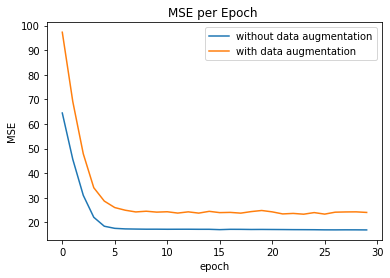

In [ ]:
plt.title("MSE per Epoch ")
plt.ylabel("MSE")
plt.xlabel("epoch")
plt.plot(mses, label ="without data augmentation")
plt.plot(aug_mses, label = "with data augmentation")
plt.legend()
plt.show()